# Importamos Librerías

In [1]:
import requests
import os
import warnings
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pickle

from nltk.stem import WordNetLemmatizer
from nltk import download
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

# Cargamos Dataset

In [2]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=435&path=url_spam.csv"
filename = "url_spam.csv"#os.path.basename(url)

save_dir = os.path.join(os.path.pardir, "data", "raw")
save_path = os.path.join(save_dir, filename)

os.makedirs(os.path.dirname(save_path), exist_ok=True)

response = requests.get(url)
with open(save_path, 'wb') as f:
    f.write(response.content)

print(f"Archivo guardado en: {save_path}")

Archivo guardado en: ../data/raw/url_spam.csv


In [3]:
# Ruta relativa al archivo desde src/
csv_path = os.path.join(os.path.pardir, "data", "raw", filename)

# Cargar el dataset en una variable (DataFrame)
total_data = pd.read_csv(csv_path)

total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


# Preprocesar los Enlaces

## Transformación de Boolean a Int

In [4]:
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


## Eliminamos valores repetidos

In [5]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.is_spam == 1])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


Vemos que el conjunto de datos no es balanceado, pues hay muchos más registros que no son considerado spam.

In [6]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

Vemos que se eliminaron 630 valores duplicados.

## Procesamiento de Texto

Procesamos las URLs para eliminar los signos de puntuación y separar cada elemento de la URL con un espacio.

In [7]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

def preprocess_url(url):
    url = str(url)
    url = re.sub(r"https?://", "", url)
    url = re.sub(r"[./?=#&-]", " ", url)
    tokens = url.lower().split()
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

total_data["url"] = total_data["url"].apply(preprocess_url)
total_data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,url,is_spam
0,briefingday us8 list manage com unsubscribe,1
1,www hvper com,1
2,briefingday com v4n3i4f3,1
3,briefingday com 20200618 commentform,0
4,briefingday com fan,1


Usaremos WordCloud para visualizar gráficamente las palabras que tienen más relevancia dentro del dataset.

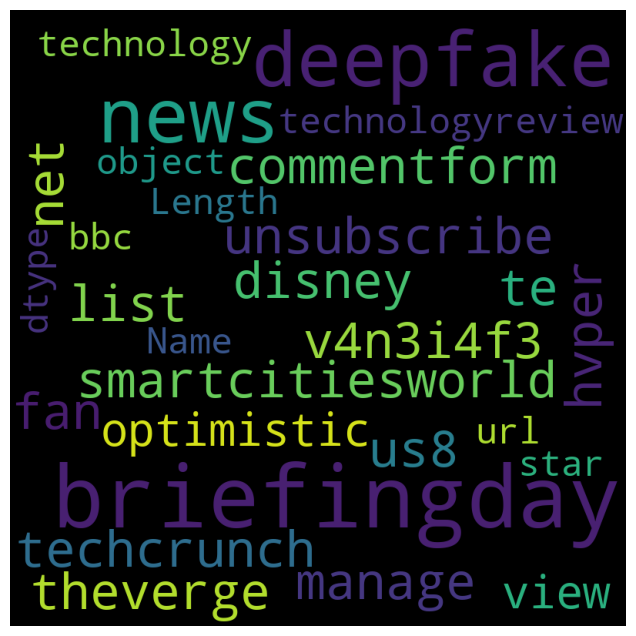

In [8]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Podemos ver que palabras como briefingday, news y deepfake son las más relevante.

## Vectorizar Dataset

In [9]:
tokens_list = total_data["url"]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 665))

## Dividimos el Dataset en datos de entrenamiento y datos de prueba

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Construye un SVM

## Inicialización y Entrenamiento del Modelo

In [11]:
accuracy_results = []

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Predicción del Modelo

In [12]:
y_pred = model.predict(X_test)

accuracy_results.append(accuracy_score(y_test, y_pred))

print("Accuracy:", accuracy_results)
print("Mejor Accuracy:", max(accuracy_results))

Accuracy: [0.9620253164556962]
Mejor Accuracy: 0.9620253164556962


El accuracy del modelo, de un 96%, es bastante bueno.

## Guardamos el Modelo

In [13]:
pickle.dump(model, open("../models/svm_classifier.sav", "wb"))

# Optimizamos el Modelo

In [14]:
svc = SVC(random_state = 42)

param_dist = {
    "C": np.logspace(-3, 2, 6),        
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"]        
}

random_search = RandomizedSearchCV(
    estimator = svc,
    param_distributions = param_dist,
    n_iter = 20,             
    scoring = "accuracy",
    cv = 5,                  
    random_state = 42,
    n_jobs = -1              
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Mejores hiperparámetros:", random_search.best_params_)
print("Accuracy en test:", accuracy)

Mejores hiperparámetros: {'kernel': 'poly', 'gamma': 'scale', 'C': np.float64(10.0)}
Accuracy en test: 0.9578059071729957


Vemos que, intentando optimizar el modelo, hemos obtenido un menor accuracy, por lo que nos quedamos con el modelo anterior.

## Guardamos el Modelo

In [15]:
pickle.dump(model, open("../models/svm_classifier_linear_42.sav", "wb"))